In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import numpy as np
from numpy.linalg import slogdet
import matplotlib.pyplot as plt
import math
import scipy
import scipy.linalg as sl
import scipy.linalg.interpolative as sli

#bempp.api.enable_console_logging()

In [2]:
center1 = (1.5, 0, 0) # center of one sphere
center2 = (-1.5, 0, 0) 
h = 0.2

wavenumber = 1j*2

sphere1 = bempp.api.shapes.sphere(h=h, origin=center1)
sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)

rwg1_ss = bempp.api.function_space(sphere1, "RWG", 0)
rwg2_ss = bempp.api.function_space(sphere2, "RWG", 0)

snc1_ss = bempp.api.function_space(sphere1, "SNC", 0)
snc2_ss = bempp.api.function_space(sphere2, "SNC", 0)

In [3]:
op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg1_ss, snc1_ss, wavenumber)
op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg2_ss, snc2_ss, wavenumber)
op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg2_ss, snc2_ss, wavenumber)
op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg1_ss, snc1_ss, wavenumber)

mat11 = np.real(bempp.api.as_matrix(op11.weak_form()))
mat12 = np.real(bempp.api.as_matrix(op12.weak_form()))
mat21 = np.real(bempp.api.as_matrix(op21.weak_form()))
mat22 = np.real(bempp.api.as_matrix(op22.weak_form()))
ident_mat = np.identity(mat11.shape[0])

A1 = ident_mat - np.linalg.inv(mat11)@mat12@np.linalg.inv(mat22)@mat21

#### Single level scheme

In [4]:
def get_box1(nx, ny, A, nboxes, n):
    """Return the content of a given box"""
    size = n // nboxes
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return A[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [5]:
def plot_box_ranks1(A, nboxes, n, tol=1E-8):
    """Plot rank of the boxes."""
    from scipy.linalg import svdvals
    ranks = np.zeros((nboxes,nboxes),dtype='int32')
    for i in range(nboxes):
        for j in range(nboxes):
            m = get_box1(i, j, A, nboxes, n)
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    plt.imshow(ranks, cmap='Accent')
    plt.colorbar()

In [6]:
n = A1.shape[0]
nboxes = 24
size = n//nboxes

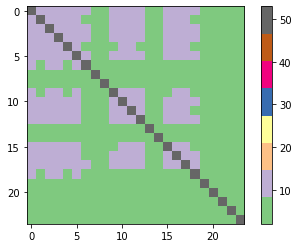

In [7]:
plot_box_ranks1(A1,nboxes,n)

In [8]:
def get_con_box1(i,A,nboxes,n):
    """Return Ai"""
    BB = A[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(A[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [9]:
def L_1(i,k,A,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box1(i,A,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box1(i,A,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [10]:
def index_set1(k,A,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L_1(i,k,A,nboxes,n)[1][0:k])
    return l

In [11]:
def S_1(k,A,nboxes,n):
    ll = index_set1(k,A,nboxes,n)
    mat = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ =  get_box1(i,j,A,nboxes,n)[ll[i],:]
                mat[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat

In [12]:
def R_1(i,k,A,nboxes,n):
    RR = np.transpose(L_1(i,k,A,nboxes,n)[0])
    return RR

In [13]:
def new_S_1(k,A,nboxes,n):
    mat_ = S_1(k,A,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R_1(i,k,A,nboxes,n) @ np.linalg.inv(get_box1(i,i,A,nboxes,n)) @ L_1(i,k,A,nboxes,n)[0])
    return mat_

In [14]:
def logdet_level1(k,A,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S_1(k,A,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box1(i,i,A,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R_1(i,k,A,nboxes,n)@np.linalg.inv(get_box1(i,i,A,nboxes,n)) @L_1(i,k,A,nboxes,n)[0])
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [15]:
sign, logdet = slogdet(A1)
print(logdet)

-0.001850630649946738


In [16]:
relative_error_level1 = []
for i in range(1,size+1):
    relative_error_level1.append(abs((logdet_level1(i,A1,nboxes,n) - logdet)/logdet))

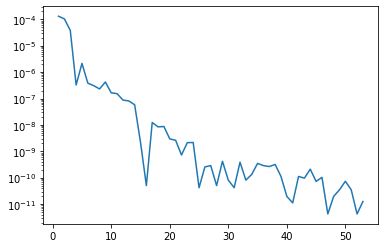

In [17]:
plt.semilogy(np.linspace(1,size,size), relative_error_level1)

#### Second level scheme

In [18]:
def plot_box_rank2(k, nboxes, n, tol=1E-8):
    """Plot rank of the boxes in level 2."""
    from scipy.linalg import svdvals
    ranks = np.zeros((nboxes//2,nboxes//2),dtype='int32')
    mat = S_1(k,A1,nboxes,n)
    for i in range(nboxes//2):
        for j in range(nboxes//2):
            m = mat[k*2*i:k*2*(i+1),k*2*j:k*2*(j+1)]
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    print(ranks)
    plt.imshow(ranks, cmap='Accent')
    plt.colorbar()

[[16 10 10  7  8 10  8  8  9  8  6  6]
 [10 16 10  8  9 10  9  9 10  9  6  6]
 [10 10 16  8  8 10  8  9 10  8  6  6]
 [ 7  8  8  6  6  8  6  6  8  6  4  4]
 [ 8  9  8  6  8  9  7  7  8  7  4  4]
 [10  9  8  8  8 16  9  9 10  8  6  6]
 [ 9 10  8  7  7 10  8  7  8  8  6  6]
 [ 8  8  8  6  7  8  7  8  9  6  5  5]
 [ 9 10 10  7  9 10  9  9 16  8  6  6]
 [ 9  9  7  7  7  8  7  7  7  8  5  5]
 [ 5  6  6  4  4  5  4  4  6  4  4  2]
 [ 4  4  4  3  4  5  4  4  4  4  2  4]]


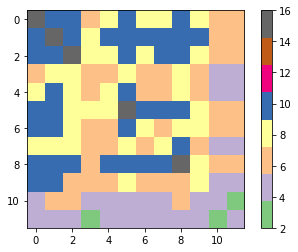

In [19]:
plot_box_rank2(10,nboxes,n)

In [18]:
def get_box2(i,j,k,A,nboxes,n): 
    '''Get boxes from S matrix in single level scheme'''
    return S_1(k,A,nboxes,n)[i*2*k:(i+1)*2*k,j*2*k:(j+1)*2*k]

In [25]:
def get_con_box2(i,k,A,nboxes,n):
    """Return Ai in the second level"""
    BB = S_1(k,A,nboxes,n)[i*2*k : (i+1)*2*k, :]
    B = np.delete(BB, np.s_[i*2*k : (i+1)*2*k], axis = 1)
    
    CC = np.transpose(S_1(k,A,nboxes,n)[:, i*2*k : (i+1)*2*k])
    C = np.delete(CC, np.s_[i*2*k : (i+1)*2*k], axis = 1)
    return np.hstack((B,C))

In [34]:
def L_2(i,k,k2,A,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box2(i,k,A,nboxes,n), k2, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box2(i,k,A,nboxes,n),k2,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k2, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [27]:
def index_set2(k,k2,A,nboxes,n):
    l = []
    for i in range(nboxes//2):
        l.append(L_2(i,k,k2,A,nboxes,n)[1][0:k2])
    return l

In [28]:
def S_2(k,k2,A,nboxes,n):
    ll = index_set2(k,k2,A,nboxes,n)
    mat = np.zeros((k2*(nboxes//2),k2*(nboxes//2)))
    for i in range(nboxes//2):
        for j in range(nboxes//2):
            if i != j:
                mat_ =  S_1(k,A,nboxes,n)[i*2*k:(i+1)*2*k,j*2*k:(j+1)*2*k][ll[i],:]
                mat[i*k2:(i+1)*k2,j*k2:(j+1)*k2] = mat_[:,ll[j]]
    return mat

In [29]:
def R_2(i,k,k2,A,nboxes,n):
    RR = np.transpose(L_2(i,k,k2,A,nboxes,n)[0])
    return RR

In [45]:
def new_S_2(k,k2,A,nboxes,n):
    mat_ = S_2(k,k2,A,nboxes,n)
    for i in range(nboxes//2):
        mat_[k2*i:k2*(i+1),k2*i:k2*(i+1)] = np.linalg.inv(R_2(i,k,k2,A,nboxes,n)@np.linalg.inv(new_S_1(k,A,nboxes,n)[2*k*i:2*k*(i+1),2*k*i:2*k*(i+1)])@L_2(i,k,k2,A,nboxes,n)[0])
    return mat_ 

In [47]:
def logdet_level2(k,k2,A,nboxes,n):
    
    a1 = 0                   #========================== D1 =============================tick
    for i in range (nboxes):
        p1,l1,u1 = scipy.linalg.lu(get_box1(i,i,A,nboxes,n))
        for j in range(size):
            a1 +=math.log(abs(u1[j,j]))
            
    a2 = 0     
    for i in range(nboxes//2):
        p2,l2,u2 = scipy.linalg.lu(np.identity(k) - R_1(i,k,A,nboxes,n)@np.linalg.inv(get_box1(i,i,A,nboxes,n)) @L_1(i,k,A,nboxes,n)[0]@ S_1(k,A,nboxes,n)[i*k:(i+1)*k,(i+1)*k:(i+2)*k]\
                                   @ R_1(i+1,k,A,nboxes,n)@np.linalg.inv(get_box1(i+1,i+1,A,nboxes,n)) @L_1(i+1,k,A,nboxes,n)[0] @ S_1(k,A,nboxes,n)[(i+1)*k:(i+2)*k,i*k:(i+1)*k] )
        for j in range(2*k):
            a2 += math.log(abs(u2[j,j]))
            

    a3 = 0                  #================= -R2.inv(X)L2 ===============================
    for i in range(nboxes//2):
        p3,l3,u3 = scipy.linalg.lu(new_S_2(k,k2,A,nboxes,n))
        for j in range(k2):
            a5 += math.log(abs(u3[j,j]))            
            
    return a1  + a2 +  a3 

In [50]:
a2 = 0     
for i in range(nboxes//2):
    p2,l2,u2 = scipy.linalg.lu(np.identity(k) - R_1(i,k,A1,nboxes,n)@np.linalg.inv(get_box1(i,i,A1,nboxes,n)) @L_1(i,k,A1,nboxes,n)[0]@ S_1(k,A1,nboxes,n)[i*k:(i+1)*k,(i+1)*k:(i+2)*k]\
                               @ R_1(i+1,k,A,nboxes,n)@np.linalg.inv(get_box1(i+1,i+1,A,nboxes,n)) @L_1(i+1,k,A,nboxes,n)[0] @ S_1(k,A,nboxes,n)[(i+1)*k:(i+2)*k,i*k:(i+1)*k] )
    for j in range(2*k):
        a2 += math.log(abs(u2[j,j]))